In [1]:
import pod5
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 12
sys.path.insert(0, '/private/groups/brookslab/gabai/tools/NEMO/src/')
from predict import *
from plot import *
import importlib
from qc import *
from findWellPosGenes import *
importlib.reload(sys.modules['findWellPosGenes'])
from findWellPosGenes import *

In [2]:
dt_outpath = '../data/'
fig_outpath = '../figures/'

## Figure3A:

In [10]:
# read well positioned genes
nuclei_rep1 = '../data/4_dorado_20190429_chrom_well_positioned_genes_cov22_cor0.5_var7100.bed'
nuclei_rep1_gene ={}
with open(nuclei_rep1) as infile:
    for line in infile:
        line=line.strip().split('\t')
        chr, start, end, genename, strand = line[0], line[1], line[2], line[3], line[5]
        nuclei_rep1_gene[(genename, strand)] = f'{chr}:{start}-{end}'
print(f'n genes: {len(nuclei_rep1_gene)}')

n genes: 380


In [11]:
# read well positioned genes
nuclei_rep2 = '../data/4_dorado_20210615_chrom_well_positioned_genes_cov29_cor0.6_var9400.bed'
nuclei_rep2_gene ={}
with open(nuclei_rep2) as infile:
    for line in infile:
        line=line.strip().split('\t')
        chr, start, end, genename, strand = line[0], line[1], line[2], line[3], line[5]
        nuclei_rep2_gene[(genename, strand)] = f'{chr}:{start}-{end}'
print(f'n genes: {len(nuclei_rep2_gene)}')

n genes: 230


In [13]:
# read well positioned genes
sphe = '../data/4_dorado_202205_sphe_chrom__well_positioned_genes_cov16_cor0.5_var5500.bed'
sphe_gene ={}
with open(sphe) as infile:
    for line in infile:
        line=line.strip().split('\t')
        chr, start, end, genename, strand = line[0], line[1], line[2], line[3], line[5]
        sphe_gene[(genename, strand)] = f'{chr}:{start}-{end}'
print(f'n genes: {len(sphe_gene)}')

n genes: 57


In [12]:
# get shared well-positioned genes between 2 replicates
shared_nuclei_genes = list(set(nuclei_rep1_gene.keys()) & set(nuclei_rep2_gene.keys()))
print(len(shared_nuclei_genes))
# shared_nuclei_genes = list(set(nuclei_rep1_gene.keys()) & set(nuclei_rep2_gene.keys()) & set(sphe_gene.keys()))
# print(len(shared_nuclei_genes))
pregions ={}
for gene in nuclei_rep1_gene:
    if gene in shared_nuclei_genes:
        pregions[gene] = nuclei_rep1_gene[gene]

38


In [11]:
# get single reads
predfile = '../data/prediction/240912_dorado_20190429_chrom.tsv'
strand = ''
outpath = dt_outpath
na_thred = 0.2
max_meth = 200
prefix = '6_rep1_rep2_shared_38_gene_tss_modifications'
stranded = False
mtx, readnames, strands, genenames = [], [], [], []

for (genename, strand), pregion in pregions.items():
    
    print(f'start processing gene {genename}...')
    
    chrom = pregion.split(':')[0]
    locus = pregion.split(':')[1].split('-')
    pstart, pend = int(locus[0]), int(locus[1])
    with open(predfile, 'r') as infile:
        for line in tqdm(infile):
            thischrom = line.strip().split('\t')[1]
            if thischrom!= chrom:
                continue
            thisread = line.strip().split('\t')[0]
            thisstrand = 1 if line.strip().split('\t')[2] == '+' else -1
            if stranded:
                if thisstrand != strand:
                    continue
            start = int(line.strip().split('\t')[3])
            scores = line.strip().split('\t')[-1]
            scores = [float(i) for i in scores.split(',')]
            
            sortedread = [(start+i,j) for i, j in enumerate(scores)]
            if sortedread[0][0] > pend or sortedread[-1][0] < pstart: continue
            
            pos_scores = {i:-1 for i in range(pstart, pend+1)}
            poss = [i[0] for i in sortedread]
            
            left = bisect_left(poss, pstart)
            
            for i in range(left, len(sortedread)):
                pos, score = sortedread[i]
                if pos > pend:
                    break
                if pos not in pos_scores:
                    continue
                pos_scores[pos] = score
            
            thisscores = np.array([v for v in pos_scores.values()])
            # flip if the gene is on reverse strand
            thisscores = np.flip(thisscores) if strand == '-' else thisscores
            
            if np.sum(thisscores) != -1*len(thisscores):
                mtx.append(thisscores)
                readnames.append(thisread)
                strands.append(thisstrand)
                genenames.append(genename)
    print(f'finished processing gene {genename}...')

mtx = np.array(mtx, dtype = float)
mtx[mtx==-1] = np.nan
readnames = np.array(readnames, dtype = str)
strands = np.array(strands, dtype = int)
genenames = np.array(genenames, dtype = str)

print('number of reads before filtering:', len(readnames))
print(f'filtering reads with more than {na_thred} NA...')
little_na = np.invert(np.isnan(mtx).sum(axis = 1)>(mtx.shape[1]*na_thred))
mtx = mtx[little_na,:]
readnames = readnames[little_na]
strands = strands[little_na]
genenames = genenames[little_na]
print(f'number of reads kept: {len(readnames)}', )
print(f'filtering hyper-methylated reads...')
hyper_meth= np.invert(np.nanmean(mtx, axis = 1)>max_meth)
mtx = mtx[hyper_meth,:]
readnames = readnames[hyper_meth]
strands = strands[hyper_meth]
genenames = genenames[hyper_meth]
print(f'number of reads kept: {len(readnames)}')

outfile = outpath + prefix + '.mtx'
print('writing output to file: ', outfile)
mtxFh = open(outfile, 'w')
for line in mtx:
    mtxFh.write(','.join(np.array(line, dtype = str)) + '\n')
mtxFh.close()

outfile2 = outpath + prefix + '_rowannot.tsv'
outf = open(outfile2, 'w')
for i,j,k in zip(readnames, strands, genenames):
    outf.write(f'{i}\t{j}\t{k}\n')
outf.close()

0it [00:00, ?it/s]

start processing gene zz-YIL161W...


58289it [00:26, 2170.70it/s]
803it [00:00, 8026.52it/s]

finished processing gene zz-YIL161W...
start processing gene SMC4...


58289it [00:22, 2605.45it/s] 
1017it [00:00, 10162.69it/s]

finished processing gene SMC4...
start processing gene GLE1...


58289it [00:21, 2775.44it/s] 
1012it [00:00, 10099.83it/s]

finished processing gene GLE1...
start processing gene FMP32...


58289it [00:08, 6627.43it/s] 
1016it [00:00, 10153.01it/s]

finished processing gene FMP32...
start processing gene TOR2...


58289it [00:12, 4751.79it/s] 
1012it [00:00, 10119.60it/s]

finished processing gene TOR2...
start processing gene ALR2...


58289it [00:08, 6611.70it/s] 
1006it [00:00, 10053.71it/s]

finished processing gene ALR2...
start processing gene ATG8...


58289it [00:14, 4116.82it/s] 
1004it [00:00, 10028.39it/s]

finished processing gene ATG8...
start processing gene VPS75...


58289it [00:14, 4155.33it/s] 
1004it [00:00, 10030.59it/s]

finished processing gene VPS75...
start processing gene SEC2...


58289it [00:14, 4154.97it/s] 
950it [00:00, 9499.83it/s]

finished processing gene SEC2...
start processing gene TAF2...


58289it [00:08, 6654.67it/s] 
1006it [00:00, 10057.37it/s]

finished processing gene TAF2...
start processing gene SPT6...


58289it [00:16, 3583.57it/s] 
1007it [00:00, 10069.27it/s]

finished processing gene SPT6...
start processing gene FEX2...


58289it [00:15, 3766.19it/s] 
894it [00:00, 8929.83it/s]

finished processing gene FEX2...
start processing gene zz-YOL029C...


58289it [00:17, 3400.96it/s] 
1017it [00:00, 10162.67it/s]

finished processing gene zz-YOL029C...
start processing gene FPR4...


58289it [00:22, 2615.52it/s] 
1021it [00:00, 10192.08it/s]

finished processing gene FPR4...
start processing gene SIR1...


58289it [00:12, 4826.24it/s] 
1021it [00:00, 10205.02it/s]

finished processing gene SIR1...
start processing gene BNA5...


58289it [00:22, 2621.34it/s] 
1021it [00:00, 10185.68it/s]

finished processing gene BNA5...
start processing gene NPR3...


58289it [00:12, 4841.93it/s] 
1014it [00:00, 10133.41it/s]

finished processing gene NPR3...
start processing gene MSH6...


58289it [00:20, 2776.56it/s] 
1021it [00:00, 10189.17it/s]

finished processing gene MSH6...
start processing gene RTF1...


58289it [00:16, 3600.60it/s] 
1012it [00:00, 10117.09it/s]

finished processing gene RTF1...
start processing gene VPS60...


58289it [00:21, 2768.66it/s] 
1021it [00:00, 10179.96it/s]

finished processing gene VPS60...
start processing gene YJU2...


58289it [00:12, 4820.80it/s] 
1016it [00:00, 10157.83it/s]

finished processing gene YJU2...
start processing gene MPA43...


58289it [00:13, 4191.16it/s] 
1012it [00:00, 10109.19it/s]

finished processing gene MPA43...
start processing gene HOM6...


58289it [00:14, 4045.48it/s] 
1021it [00:00, 10180.81it/s]

finished processing gene HOM6...
start processing gene ERV41...


58289it [00:13, 4176.58it/s] 
1017it [00:00, 10162.38it/s]

finished processing gene ERV41...
start processing gene PUF6...


58289it [00:21, 2772.44it/s] 
1016it [00:00, 10149.07it/s]

finished processing gene PUF6...
start processing gene CDC9...


58289it [00:21, 2745.55it/s] 
1014it [00:00, 10133.99it/s]

finished processing gene CDC9...
start processing gene YKT6...


58289it [00:12, 4768.38it/s] 
978it [00:00, 9779.50it/s]

finished processing gene YKT6...
start processing gene YPF1...


58289it [00:12, 4787.42it/s] 
914it [00:00, 9136.07it/s]

finished processing gene YPF1...
start processing gene SPR28...


58289it [00:21, 2759.04it/s] 
878it [00:00, 8776.53it/s]

finished processing gene SPR28...
start processing gene REA1...


58289it [00:22, 2611.89it/s] 
1021it [00:00, 10202.08it/s]

finished processing gene REA1...
start processing gene IMG2...


58289it [00:08, 6652.98it/s] 
1021it [00:00, 10176.72it/s]

finished processing gene IMG2...
start processing gene FOB1...


58289it [00:21, 2774.04it/s] 
1013it [00:00, 10115.30it/s]

finished processing gene FOB1...
start processing gene FET5...


58289it [00:08, 6579.71it/s] 
1007it [00:00, 10055.39it/s]

finished processing gene FET5...
start processing gene RFA2...


58289it [00:14, 4159.22it/s] 
977it [00:00, 9767.10it/s]

finished processing gene RFA2...
start processing gene IOC3...


58289it [00:08, 6614.32it/s] 
1016it [00:00, 10154.13it/s]

finished processing gene IOC3...
start processing gene RPS14B...


58289it [00:14, 4055.60it/s] 
1021it [00:00, 10191.49it/s]

finished processing gene RPS14B...
start processing gene SCH9...


58289it [00:11, 4902.97it/s] 
945it [00:00, 9447.24it/s]

finished processing gene SCH9...
start processing gene PMT5...


58289it [00:21, 2745.25it/s] 


finished processing gene PMT5...
number of reads before filtering: 1317
filtering reads with more than 0.2 NA...
number of reads kept: 966
filtering hyper-methylated reads...
number of reads kept: 925
writing output to file:  ../data/6_rep1_rep2_shared_38_gene_tss_modifications.mtx


NameError: name 'genes' is not defined

## kmeans clustering of reads within each gene

In [7]:
mtx = []
with open('../data/6_rep1_rep2_shared_38_gene_tss_modifications.mtx', 'r') as infile:
    for line in infile:
        mod = [float(i) for i in line.strip().split(',')]
        mtx.append(mod)

readnames, strands, genenames = [], [], []
with open('../data/6_rep1_rep2_shared_38_gene_tss_modifications_rowannot.tsv', 'r') as infile:
    for line in infile:
        line = line.strip().split('\t')
        readnames.append(str(line[0]))
        strands.append(str(line[1]))
        genenames.append(str(line[2]))


mtx = np.array(mtx, dtype = float)
readnames = np.array(readnames, dtype = str)
strands = np.array(strands, dtype = int)
genenames = np.array(genenames, dtype = str)

In [8]:
import pandas as pd
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.impute import SimpleImputer

In [14]:
if np.isnan(mtx).sum() != 0:
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    new_mtx = imp.fit_transform(mtx)
else:
    new_mtx = mtx

df = pd.DataFrame(new_mtx)
df['gene'] = genenames  # Add the gene annotation to the matrix as a new column

# Group the matrix by gene
df['gene'] = pd.Categorical(df['gene'], categories=[i[0] for i in pregions][::-1], ordered=True)
df = df.sort_values('gene')

grouped_by_gene = df.groupby('gene', sort=False)

# Function for KMeans clustering for each gene
def kmeans_clustering_for_gene(gene_group, n_clusters=3):
    # Exclude the 'gene' column for clustering
    gene_reads = gene_group.drop(columns=['gene'])
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(gene_reads)
    
    # Add the cluster labels as a new column
    gene_group['cluster'] = clusters
    
    # Sort the rows by cluster labels
    sorted_gene_group = gene_group.sort_values(by='cluster')
    
    return sorted_gene_group.drop(columns=['cluster'])  # Drop the cluster column after sorting

# Function for hierarchical clustering for each gene
def hierarchical_clustering_for_gene(gene_group, method='ward', n_clusters=3):
    # Exclude the 'gene' column for clustering
    gene_reads = gene_group.drop(columns=['gene'])
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(gene_reads, method=method)
    
    # Get the flat clusters based on n_clusters
    clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    
    # Add the cluster labels as a new column
    gene_group['cluster'] = clusters
    
    # Sort the rows by cluster labels
    sorted_gene_group = gene_group.sort_values(by='cluster')
    
    return sorted_gene_group.drop(columns=['cluster'])  # Drop the cluster column after sorting

# 1. Apply clustering on each gene group and collect sorted groups
sorted_groups, clustered_genes = [], []

for gene_name, gene_group in grouped_by_gene:
    print(f"Clustering for {gene_name}")
    
    # Choose KMeans or Hierarchical clustering
    sorted_gene_group = kmeans_clustering_for_gene(gene_group, n_clusters=3)
    # Alternatively, use hierarchical clustering:
    # sorted_gene_group = hierarchical_clustering_for_gene(gene_group, n_clusters=3)

    # Append the sorted group to the list
    sorted_groups.append(sorted_gene_group.drop(columns=['gene']))  # Remove 'gene' column

    clustered_genes.extend([gene_name] * len(sorted_gene_group))
# 2. Concatenate all sorted groups back into one matrix
clustered_mtx = pd.concat(sorted_groups, axis=0).values  # Convert to numpy array

# The final output matrix
print("clustered matrix shape:", clustered_mtx.shape)

/data/tmp/ipykernel_1760020/1171544895.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_gene = df.groupby('gene', sort=False)
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/sit

Clustering for PMT5
Clustering for SCH9


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for RPS14B


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for IOC3


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for RFA2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for FET5


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for FOB1


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for IMG2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for REA1


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for SPR28


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for YPF1


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for YKT6


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for CDC9


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for PUF6


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for ERV41


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for HOM6


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for MPA43


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for YJU2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for VPS60


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for RTF1


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for MSH6


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for NPR3


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for BNA5


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for SIR1


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for FPR4


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for zz-YOL029C


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for FEX2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for SPT6


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for TAF2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for SEC2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for VPS75


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for ATG8


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for ALR2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for TOR2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for FMP32


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for GLE1


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for SMC4


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for zz-YIL161W


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


clustered matrix shape: (925, 1201)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 925/925 [20:40<00:00,  1.34s/it]


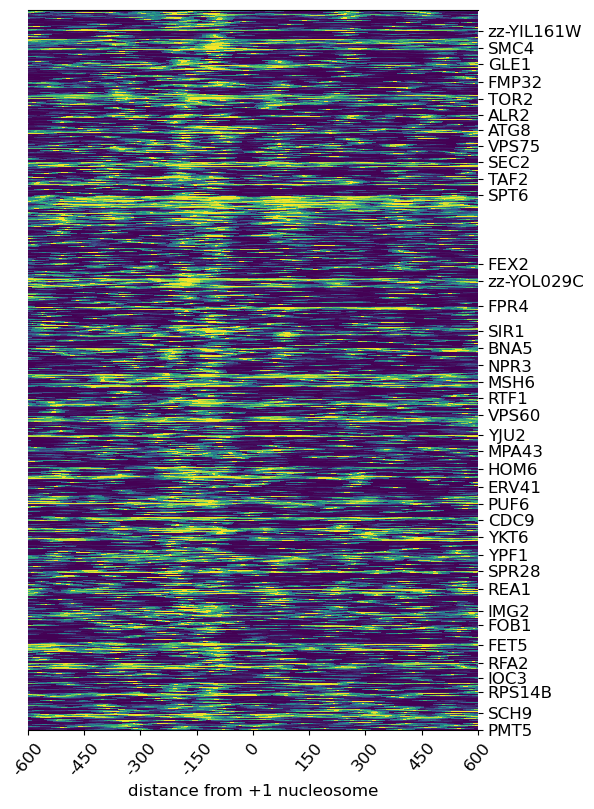

In [218]:
plt.figure(figsize=(5, 8))
pstart, pend = (-600, 600)
xticks_space = 150
ax = plt.axes((0.1, 0.1, 0.9, 0.9))
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(ticks= np.arange(pstart, pend+1, xticks_space))
ax.set_xticklabels(ax.get_xticks(), rotation = 50)
ax.set_xlim(pstart, pend)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
height = (1, 1)
bottom=0
tick_yaxis, label_yaxis = [],[]
total, count = np.zeros(clustered_mtx.shape[1], dtype = int), np.zeros(clustered_mtx.shape[1], dtype = int)
(R,G,B) = colorMap(palette = 'viridis', log_scale=False)
thisgene = ''

for i in tqdm(range(clustered_mtx.shape[0])):
    left = -600
    if thisgene != clustered_genes[i]:
        tick_yaxis.append(bottom)
        label_yaxis.append(clustered_genes[i])
        thisgene = clustered_genes[i]
    for j in range(clustered_mtx.shape[1]):
        score = clustered_mtx[i, j]
        if not np.isnan(score):
            count[j] += score
            total[j] += 1
        # no score at this position
        if np.isnan(score):
            col = 'lightgray'
        else:
            color = int((score/256)*100)
            col=(R[color],G[color],B[color])
        thisalpha = 1
        rectangle = mplpatches.Rectangle([left, bottom-(height[0]*0.5)], 1, height[0], 
                                         facecolor = col, edgecolor = 'silver', linewidth = 0, alpha=thisalpha)
        ax.add_patch(rectangle)
        left += 1
    bottom +=height[0]

aggregate = np.divide(np.divide(count, total), 256)
if np.max(total) < 1:
    aggregate = np.zeros(clustered_mtx.shape[1])
ax.bar(np.arange(pstart, pend+1), aggregate, bottom=bottom, width = 1.0, color = 'tab:blue')
ax.set_yticks(ticks = tick_yaxis, labels = label_yaxis)
ax.set_ylim(0-0.5*height[0], bottom)
ax.set_xlabel('distance from +1 nucleosome')
plt.savefig(fig_outpath+ f'6_top_well_positioned_genes_clustered_within_gene.pdf', bbox_inches='tight')

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 925/925 [00:08<00:00, 115.37it/s]


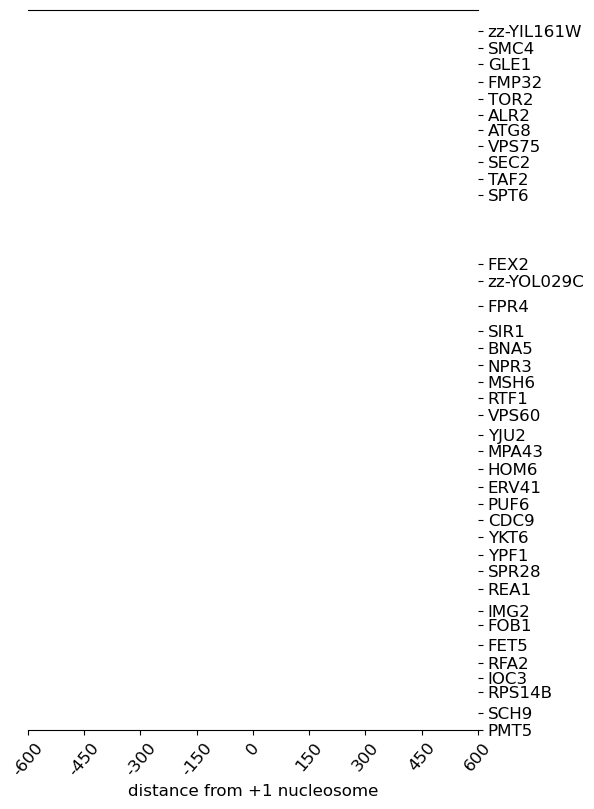

In [15]:
plt.figure(figsize=(5, 8))
pstart, pend = (-600, 600)
xticks_space = 150
ax = plt.axes((0.1, 0.1, 0.9, 0.9))
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(ticks= np.arange(pstart, pend+1, xticks_space))
ax.set_xticklabels(ax.get_xticks(), rotation = 50)
ax.set_xlim(pstart, pend)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
height = (1, 1)
bottom=0
tick_yaxis, label_yaxis = [],[]
total, count = np.zeros(clustered_mtx.shape[1], dtype = int), np.zeros(clustered_mtx.shape[1], dtype = int)
(R,G,B) = colorMap(palette = 'viridis', log_scale=False)
thisgene = ''

for i in tqdm(range(clustered_mtx.shape[0])):
    left = -600
    if thisgene != clustered_genes[i]:
        tick_yaxis.append(bottom)
        label_yaxis.append(clustered_genes[i])
        thisgene = clustered_genes[i]
    for j in range(clustered_mtx.shape[1]):
        score = clustered_mtx[i, j]
        if not np.isnan(score):
            count[j] += score
            total[j] += 1
        # no score at this position
        if np.isnan(score):
            col = 'lightgray'
        else:
            color = int((score/256)*100)
            col=(R[color],G[color],B[color])
        thisalpha = 1
        # rectangle = mplpatches.Rectangle([left, bottom-(height[0]*0.5)], 1, height[0], 
                                         # facecolor = col, edgecolor = 'silver', linewidth = 0, alpha=thisalpha)
        # ax.add_patch(rectangle)
        left += 1
    bottom +=height[0]

aggregate = np.divide(np.divide(count, total), 256)
if np.max(total) < 1:
    aggregate = np.zeros(clustered_mtx.shape[1])
ax.bar(np.arange(pstart, pend+1), aggregate, bottom=bottom, width = 1.0, color = 'tab:blue')
ax.set_yticks(ticks = tick_yaxis, labels = label_yaxis)
ax.set_ylim(0-0.5*height[0], bottom)
ax.set_xlabel('distance from +1 nucleosome')
plt.savefig(fig_outpath+ f'6_top_well_positioned_genes_clustered_within_gene_text_only.pdf', bbox_inches='tight')

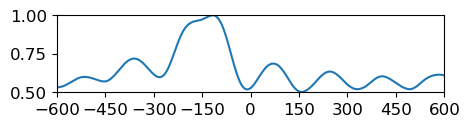

In [38]:
from scipy.signal import savgol_filter
smoothed_agg = savgol_filter(aggregate, 150, 3, mode="nearest")
peak = max(smoothed_agg)
smoothed_agg = smoothed_agg/peak
plt.figure(figsize=(5, 1))
plt.plot(np.arange(pstart, pend+1), smoothed_agg)
plt.xticks(ticks= np.arange(pstart, pend+1, xticks_space))
plt.yticks(ticks= [0.5, 0.75, 1.0])
plt.ylim(0.5, max(smoothed_agg))
plt.xlim(-600, 600)
plt.savefig(fig_outpath+ f'6_top_aggregated_panel_rep1.pdf', bbox_inches='tight')

In [ ]:
chrom_190429_pred = '/private/groups/brookslab/gabai/projects/Add-seq/data/chrom/modPredict/240905_prediction/240912_dorado_20190429_chrom.tsv'
gtfFile = '/private/groups/brookslab/gabai/projects/Add-seq/data/ref/Saccharomyces_cerevisiae.R64-1-1.109.gtf'

for genename, regions in pregions.items():
    plotModTrack(chrom_190429_pred, regions, ncluster=2, outpath='../figures/Figure3_all/', prefix= f'Figure3A_{genename[0]}', 
             gtfFile=gtfFile, xticks_space = 150, na_thred=0.2)

preprocessing input matrix...


58289it [00:15, 3800.23it/s] 


number of reads before filtering: 48
number of reads kept: 27
writing output to file:  ../figures/Figure3_all/Figure3A_zz-YIL161W_chrIX:38868-40068.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [01:00<00:00,  2.22s/it]


preprocessing input matrix...


58289it [00:22, 2596.27it/s] 


number of reads before filtering: 36
number of reads kept: 23
writing output to file:  ../figures/Figure3_all/Figure3A_SMC4_chrXII:301632-302832.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:27<00:00,  1.18s/it]


preprocessing input matrix...


58289it [00:21, 2679.37it/s] 


number of reads before filtering: 31
number of reads kept: 21
writing output to file:  ../figures/Figure3_all/Figure3A_GLE1_chrIV:87675-88875.mtx
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:25<00:00,  1.19s/it]


preprocessing input matrix...


58289it [00:09, 6185.66it/s] 


number of reads before filtering: 28
number of reads kept: 24
writing output to file:  ../figures/Figure3_all/Figure3A_FMP32_chrVI:42235-43435.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:28<00:00,  1.19s/it]


preprocessing input matrix...


58289it [00:12, 4548.64it/s] 


number of reads before filtering: 29
number of reads kept: 22
writing output to file:  ../figures/Figure3_all/Figure3A_TOR2_chrXI:62898-64098.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:26<00:00,  1.21s/it]


preprocessing input matrix...


58289it [00:09, 6258.75it/s] 


number of reads before filtering: 33
number of reads kept: 23
writing output to file:  ../figures/Figure3_all/Figure3A_ALR2_chrVI:35968-37168.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:27<00:00,  1.17s/it]


preprocessing input matrix...


58289it [00:14, 4042.94it/s] 


number of reads before filtering: 32
number of reads kept: 21
writing output to file:  ../figures/Figure3_all/Figure3A_ATG8_chrII:80111-81311.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.17s/it]


preprocessing input matrix...


58289it [00:14, 4091.12it/s] 


number of reads before filtering: 31
number of reads kept: 22
writing output to file:  ../figures/Figure3_all/Figure3A_VPS75_chrXIV:184892-186092.mtx
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.14s/it]


preprocessing input matrix...


58289it [00:14, 4135.78it/s] 


number of reads before filtering: 38
number of reads kept: 23
writing output to file:  ../figures/Figure3_all/Figure3A_SEC2_chrXIV:128537-129737.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:26<00:00,  1.16s/it]


preprocessing input matrix...


58289it [00:09, 6305.49it/s] 


number of reads before filtering: 32
number of reads kept: 22
writing output to file:  ../figures/Figure3_all/Figure3A_TAF2_chrIII:204776-205976.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:58<00:00,  2.67s/it]


preprocessing input matrix...


58289it [00:16, 3478.04it/s] 


number of reads before filtering: 27
number of reads kept: 21
writing output to file:  ../figures/Figure3_all/Figure3A_SPT6_chrVII:719793-720993.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:25<00:00,  1.22s/it]


preprocessing input matrix...


58289it [00:16, 3639.22it/s] 


number of reads before filtering: 114
number of reads kept: 95
writing output to file:  ../figures/Figure3_all/Figure3A_FEX2_chrXVI:13765-14965.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [01:45<00:00,  1.11s/it]


preprocessing input matrix...


58289it [00:17, 3298.29it/s] 


number of reads before filtering: 31
number of reads kept: 21
writing output to file:  ../figures/Figure3_all/Figure3A_zz-YOL029C_chrXV:270938-272138.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.14s/it]


preprocessing input matrix...


58289it [00:22, 2576.94it/s] 


number of reads before filtering: 43
number of reads kept: 35
writing output to file:  ../figures/Figure3_all/Figure3A_FPR4_chrXII:1030261-1031461.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:39<00:00,  1.14s/it]


preprocessing input matrix...


58289it [00:12, 4572.20it/s] 


number of reads before filtering: 39
number of reads kept: 33
writing output to file:  ../figures/Figure3_all/Figure3A_SIR1_chrXI:639977-641177.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:38<00:00,  1.17s/it]


preprocessing input matrix...


58289it [00:22, 2597.71it/s] 


number of reads before filtering: 25
number of reads kept: 23
writing output to file:  ../figures/Figure3_all/Figure3A_BNA5_chrXII:606504-607704.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:26<00:00,  1.16s/it]


preprocessing input matrix...


58289it [00:12, 4718.80it/s] 


number of reads before filtering: 29
number of reads kept: 23
writing output to file:  ../figures/Figure3_all/Figure3A_NPR3_chrVIII:61953-63153.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:26<00:00,  1.15s/it]


preprocessing input matrix...


58289it [00:21, 2676.53it/s] 


number of reads before filtering: 37
number of reads kept: 22
writing output to file:  ../figures/Figure3_all/Figure3A_MSH6_chrIV:643274-644474.mtx
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [01:06<00:00,  3.01s/it]


preprocessing input matrix...


58289it [00:16, 3495.70it/s] 


number of reads before filtering: 26
number of reads kept: 21
writing output to file:  ../figures/Figure3_all/Figure3A_RTF1_chrVII:40901-42101.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.16s/it]


preprocessing input matrix...


58289it [00:21, 2657.32it/s] 


number of reads before filtering: 26
number of reads kept: 22
writing output to file:  ../figures/Figure3_all/Figure3A_VPS60_chrIV:1427483-1428683.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.14s/it]


preprocessing input matrix...


58289it [00:12, 4608.83it/s] 


number of reads before filtering: 31
number of reads kept: 25
writing output to file:  ../figures/Figure3_all/Figure3A_YJU2_chrXI:261562-262762.mtx
nan in output matrix!


/private/groups/brookslab/gabai/tools/NEMO/src/plot.py:101: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  


running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.14s/it]


preprocessing input matrix...


58289it [00:14, 3922.15it/s] 


number of reads before filtering: 32
number of reads kept: 22
writing output to file:  ../figures/Figure3_all/Figure3A_MPA43_chrXIV:180367-181567.mtx
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:25<00:00,  1.15s/it]


preprocessing input matrix...


58289it [00:14, 3957.16it/s] 


number of reads before filtering: 33
number of reads kept: 24
writing output to file:  ../figures/Figure3_all/Figure3A_HOM6_chrX:689975-691175.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:27<00:00,  1.15s/it]


preprocessing input matrix...


58289it [00:14, 4085.02it/s] 


number of reads before filtering: 29
number of reads kept: 25
writing output to file:  ../figures/Figure3_all/Figure3A_ERV41_chrXIII:139602-140802.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:28<00:00,  1.14s/it]


preprocessing input matrix...


58289it [00:22, 2598.03it/s] 


number of reads before filtering: 35
number of reads kept: 23
writing output to file:  ../figures/Figure3_all/Figure3A_PUF6_chrIV:1442781-1443981.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:26<00:00,  1.17s/it]


preprocessing input matrix...


58289it [00:22, 2602.60it/s] 


number of reads before filtering: 26
number of reads kept: 23
writing output to file:  ../figures/Figure3_all/Figure3A_CDC9_chrIV:166653-167853.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:27<00:00,  1.18s/it]


preprocessing input matrix...


58289it [00:12, 4596.49it/s] 


number of reads before filtering: 33
number of reads kept: 23
writing output to file:  ../figures/Figure3_all/Figure3A_YKT6_chrXI:74946-76146.mtx
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:30<00:00,  1.31s/it]


preprocessing input matrix...


58289it [00:13, 4436.08it/s] 


number of reads before filtering: 29
number of reads kept: 23
writing output to file:  ../figures/Figure3_all/Figure3A_YPF1_chrXI:254824-256024.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:30<00:00,  1.31s/it]


preprocessing input matrix...


58289it [00:22, 2594.83it/s] 


number of reads before filtering: 36
number of reads kept: 21
writing output to file:  ../figures/Figure3_all/Figure3A_SPR28_chrIV:904447-905647.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.19s/it]


preprocessing input matrix...


58289it [00:23, 2507.40it/s] 


number of reads before filtering: 30
number of reads kept: 23
writing output to file:  ../figures/Figure3_all/Figure3A_REA1_chrXII:363227-364427.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:26<00:00,  1.17s/it]


preprocessing input matrix...


58289it [00:10, 5758.10it/s] 


number of reads before filtering: 40
number of reads kept: 32
writing output to file:  ../figures/Figure3_all/Figure3A_IMG2_chrIII:239934-241134.mtx
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:36<00:00,  1.15s/it]


preprocessing input matrix...


58289it [00:22, 2646.34it/s] 


number of reads before filtering: 31
number of reads kept: 20
writing output to file:  ../figures/Figure3_all/Figure3A_FOB1_chrIV:675504-676704.mtx
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.73s/it]


preprocessing input matrix...


58289it [00:15, 3802.81it/s] 


number of reads before filtering: 34
number of reads kept: 26
writing output to file:  ../figures/Figure3_all/Figure3A_FET5_chrVI:48571-49771.mtx
nan in output matrix!
running hierarchical clustering...
Clustering with number of clusters = 2
plotting gene annotations...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:29<00:00,  1.14s/it]


preprocessing input matrix...


49048it [00:20, 358.78it/s]  